In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 46.6 MB/s eta 0:00:00


In [3]:
!pip install pinecone-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 2.0 MB/s eta 0:00:00


In [4]:
import os
from PIL import Image
import PIL
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

import torch
from datasets import Dataset, Image
from torch.utils.data import DataLoader

from typing import List, Union, Tuple

from transformers import CLIPProcessor, CLIPModel

import faiss
from pinecone import pinecone

In [5]:
device = "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
2024-04-15 12:32:55.413307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 12:32:55.413402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 12:32:55.522064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one h

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [6]:
image_path = os.listdir('/kaggle/input/flickr30k/Images/flickr30k_images/')
image_path = ['/kaggle/input/flickr30k/Images/flickr30k_images/' + path for path in image_path if '.jpg' in path]
image_path.sort()

In [7]:
captions_df = pd.read_csv('/kaggle/input/captions-csv/captions.csv')

In [8]:
def encode_images(images: Union[List[str], List[PIL.Image.Image]], batch_size: int):
    def transform_fn(el):
        if isinstance(el['image'], PIL.Image.Image):
            imgs = el['image']
        else:
            imgs = [Image().decode_example(_) for _ in el['image']]
        return preprocess(images=imgs, return_tensors='pt')
        
    dataset = Dataset.from_dict({'image': images})
    dataset = dataset.cast_column('image',Image(decode=False)) if isinstance(images[0], str) else dataset       
    dataset.set_format('torch')
    dataset.set_transform(transform_fn)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    image_embeddings = []
    pbar = tqdm(total=len(images) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            batch = {k:v.to(device) for k,v in batch.items()}
            image_embeddings.extend(model.get_image_features(**batch).detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(image_embeddings)

vector_embedding = np.array(encode_images(image_path,32))

994it [33:59,  2.05s/it]


In [9]:
def encode_text( text: List[str], batch_size: int):
    device =  "cpu"
    dataset = Dataset.from_dict({'text': text})
    dataset = dataset.map(lambda el: preprocess(text=el['text'], return_tensors="pt",
                                                        max_length=77, padding="max_length", truncation=True),
                            batched=True,
                            remove_columns=['text'])
    dataset.set_format('torch')
    dataloader = DataLoader(dataset, batch_size=batch_size)
    text_embeddings = []
    pbar = tqdm(total=len(text) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            text_embeddings.extend(model.get_text_features(**batch).detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(text_embeddings)

In [10]:
with open('flicker30k_image_embeddings.pkl','wb') as f:
    pickle.dump(vector_embedding, f)

In [11]:
import pickle
with open('/kaggle/working/flicker30k_image_embeddings.pkl', 'rb') as fp:
    vector_embedding = pickle.load(fp)

In [12]:
index = faiss.IndexFlatIP(vector_embedding.shape[1])
index.add(vector_embedding)

In [13]:
search_text = "A beautiful sunny day"
with torch.no_grad():
    text_search_embedding = encode_text([search_text], batch_size=32)
text_search_embedding = text_search_embedding/np.linalg.norm(text_search_embedding, ord=2, axis=-1, keepdims=True)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 12.57it/s]


In [14]:
distances, indices = index.search(text_search_embedding.reshape(1, -1), 5)
distances = distances[0]
indices = indices[0]

indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1])  # Sort based on the distances

print(indices_distances)

[(17270, 2.895874), (15217, 2.9022799), (6007, 2.9065218), (21597, 2.9635777), (22163, 3.1420684)]


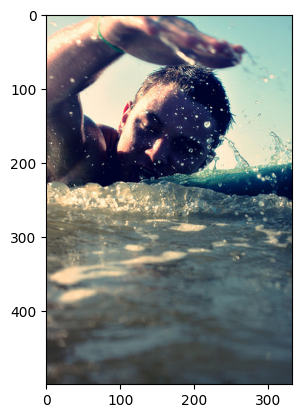

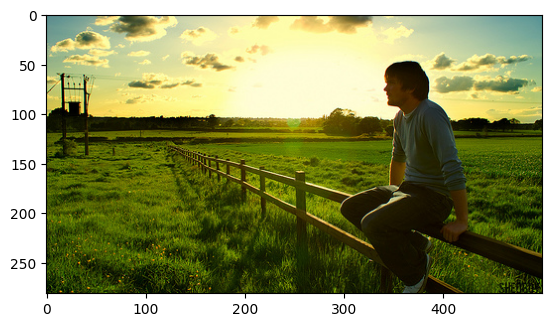

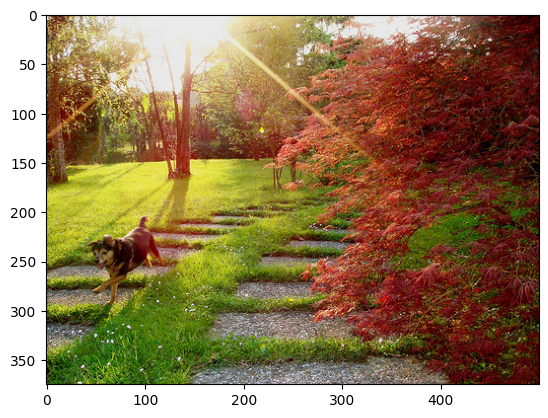

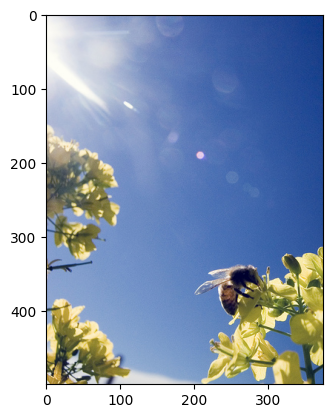

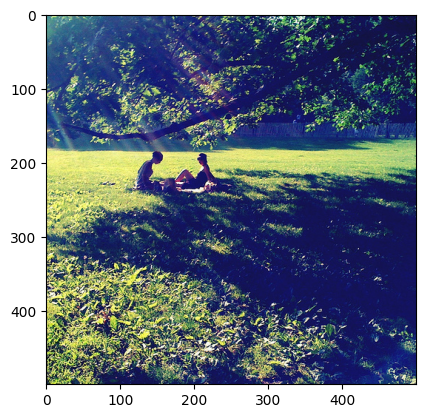

In [15]:
from PIL import Image
for idx, distance in indices_distances:
    path = image_path[idx]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()